<a href="https://colab.research.google.com/github/tsanoop887-hash/fusion-ai-model/blob/main/fusion_ai_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [27]:
device=torch .device("cuda" if torch.cuda.is_available() else "cpu" )
print("using device :",device)

using device : cpu


In [28]:
alpha = 0.01
x_min , x_max=0.0,1.0
y_min, y_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0

In [29]:
def exact_solution(x, y, t):
    """
    x, y, t: torch tensors on same device
    """
    return torch.sin(np.pi * x) * torch.sin(np.pi * y) * torch.exp(-2 * (np.pi**2) * alpha * t)


In [30]:
def sample_interior(n_samples):
    # Interior points: (x,y,t) in the open domain
    x = torch.rand(n_samples, 1) * (x_max - x_min) + x_min
    y = torch.rand(n_samples, 1) * (y_max - y_min) + y_min
    t = torch.rand(n_samples, 1) * (t_max - t_min) + t_min
    return x, y, t

In [31]:
def sample_initial(n_samples):
    # Initial condition: t = 0, x,y in [0,1]
    x = torch.rand(n_samples, 1) * (x_max - x_min) + x_min
    y = torch.rand(n_samples, 1) * (y_max - y_min) + y_min
    t = torch.zeros_like(x)
    return x, y, t

In [7]:
def sample_boundary(n_samples):
    # Boundary: x or y on edges with random t
    n_side = n_samples // 4

    xs, ys, ts = [], [], []

    # x = x_min
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    x = torch.zeros_like(t) + x_min
    y = torch.rand(n_side, 1) * (y_max - y_min) + y_min
    xs.append(x); ys.append(y); ts.append(t)


        # x = x_max
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    x = torch.zeros_like(t) + x_max
    y = torch.rand(n_side, 1) * (y_max - y_min) + y_min
    xs.append(x); ys.append(y); ts.append(t)

    # y = y_min
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    y = torch.zeros_like(t) + y_min
    x = torch.rand(n_side, 1) * (x_max - x_min) + x_min
    xs.append(x); ys.append(y); ts.append(t)

    # y = y_max
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    y = torch.zeros_like(t) + y_max
    x = torch.rand(n_side, 1) * (x_max - x_min) + x_min
    xs.append(x); ys.append(y); ts.append(t)

    x = torch.cat(xs, dim=0)
    y = torch.cat(ys, dim=0)
    t = torch.cat(ts, dim=0)
    return x, y, t







In [32]:
class PINN(nn.Module):
    def __init__(self, in_dim=3, hidden_dim=64, out_dim=1, n_layers=5):
        super().__init__()
        layers = []
        dims = [in_dim] + [hidden_dim] * (n_layers - 1) + [out_dim]

        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.Tanh())   # smoother for PDEs

        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)



In [33]:
def pinn_pde_residual(model, x, y, t):
    """
    Compute PDE residual:
       r = ∂T/∂t - α ( ∂²T/∂x² + ∂²T/∂y² )
    """
    x = x.clone().detach().requires_grad_(True).to(device)
    y = y.clone().detach().requires_grad_(True).to(device)
    t = t.clone().detach().requires_grad_(True).to(device)

    inp = torch.cat([x, y, t], dim=1)
    T = model(inp)

    # First derivatives
    dT_dt = torch.autograd.grad(
        T, t, torch.ones_like(T), retain_graph=True, create_graph=True
    )[0]
    dT_dx = torch.autograd.grad(
        T, x, torch.ones_like(T), retain_graph=True, create_graph=True
    )[0]
    dT_dy = torch.autograd.grad(
        T, y, torch.ones_like(T), retain_graph=True, create_graph=True
    )[0]

    # Second derivatives
    d2T_dx2 = torch.autograd.grad(
        dT_dx, x, torch.ones_like(dT_dx), retain_graph=True, create_graph=True
    )[0]
    d2T_dy2 = torch.autograd.grad(
        dT_dy, y, torch.ones_like(dT_dy), retain_graph=True, create_graph=True
    )[0]

    residual = dT_dt - alpha * (d2T_dx2 + d2T_dy2)
    return residual

In [35]:
class SpectralConv2d(nn.Module):
    """
    2D spectral convolution using truncated Fourier modes.
    This is a simplified FNO spectral layer.
    """

    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1.0 / (in_channels * out_channels)
        # Last dimension = 2 for (real, imag)
        self.weight = nn.Parameter(
            self.scale
            * torch.randn(in_channels, out_channels, modes1, modes2, 2)
        )

In [36]:
class SpectralConv2d(nn.Module):
    """
    2D spectral convolution using truncated Fourier modes.
    This is a simplified FNO spectral layer.
    """

    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1.0 / (in_channels * out_channels)
        # Last dimension = 2 for (real, imag)
        self.weight = nn.Parameter(
            self.scale
            * torch.randn(in_channels, out_channels, modes1, modes2, 2)
        )

    def complex_mul(self, input, weights):
        # input:  (b, in_c, m1, m2)
        # weight: (in_c, out_c, m1, m2)
        return torch.einsum("bixy,ioxy->boxy", input, weights)


    def forward(self, x):
        """
        x: (b, in_c, nx, ny)
        """
        b, c, nx, ny = x.shape
        x_ft = torch.fft.rfft2(x, norm="ortho")  # (b,c,nx,ny//2+1)

        # Build complex weights
        weight_c = torch.view_as_complex(self.weight)  # (in_c,out_c,m1,m2)

        out_ft = torch.zeros(
            b,
            self.out_channels,
            nx,
            ny // 2 + 1,
            dtype=torch.complex64,
            device=x.device,
        )

        m1 = min(self.modes1, nx)
        m2 = min(self.modes2, ny // 2 + 1)

        x_ft_low = x_ft[:, : self.in_channels, :m1, :m2]
        out_ft[:, :, :m1, :m2] = self.complex_mul(x_ft_low, weight_c[:, :, :m1, :m2])

        x = torch.fft.irfft2(out_ft, s=(nx, ny), norm="ortho")
        return x

In [38]:
class FNO2d(nn.Module):
    """
    Simple 2D FNO-like model mapping (x,y,t) grid -> T(x,y,t)
    """

    def __init__(self, in_channels=3, width=32, modes1=12, modes2=12):
        super().__init__()
        self.width = width

        self.fc0 = nn.Linear(in_channels, width)

        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        self.conv3 = SpectralConv2d(width, width, modes1, modes2)
        self.conv4 = SpectralConv2d(width, width, modes1, modes2)

        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        self.w3 = nn.Conv2d(width, width, 1)
        self.w4 = nn.Conv2d(width, width, 1)

        self.fc1 = nn.Linear(width, 64)
        self.fc2 = nn.Linear(64, 1)

        self.act = nn.GELU()

    def forward(self, x):
        """
        x: (b, nx, ny, in_channels)
        returns: (b, nx, ny, 1)
        """
        b, nx, ny, ic = x.shape
        x = self.fc0(x)              # (b, nx, ny, width)
        x = x.permute(0, 3, 1, 2)    # (b, width, nx, ny)

        x1 = self.conv1(x)
        x = x1 + self.w1(x)
        x = self.act(x)

        x1 = self.conv2(x)
        x = x1 + self.w2(x)
        x = self.act(x)

        x1 = self.conv3(x)
        x = x1 + self.w3(x)
        x = self.act(x)

        x1 = self.conv4(x)
        x = x1 + self.w4(x)
        x = self.act(x)

        x = x.permute(0, 2, 3, 1)    # (b, nx, ny, width)
        x = self.act(self.fc1(x))
        x = self.fc2(x)              # (b, nx, ny, 1)
        return x

In [40]:
def generate_grid(nx=64, ny=64, nt=10):
    xs = torch.linspace(x_min, x_max, nx)
    ys = torch.linspace(y_min, y_max, ny)
    ts = torch.linspace(t_min, t_max, nt)

    grids = []
    fields = []

    for t in ts:
        X, Y = torch.meshgrid(xs, ys, indexing="ij")
        T = exact_solution(X, Y, t)

        inp = torch.stack(
            [X, Y, torch.ones_like(X) * t], dim=-1
        )  # (nx, ny, 3)
        grids.append(inp)
        fields.append(T.unsqueeze(-1))  # (nx, ny, 1)

    grids = torch.stack(grids, dim=0)   # (nt, nx, ny, 3)
    fields = torch.stack(fields, dim=0) # (nt, nx, ny, 1)
    return grids, fields


    grids, fields = generate_grid(nx=32, ny=32, nt=12)
grids = grids.to(device)
fields = fields.to(device)

print("FNO training data shape:", grids.shape, fields.shape)

FNO training data shape: torch.Size([12, 32, 32, 3]) torch.Size([12, 32, 32, 1])


Epoch  100 | PINN Loss: 7.8384e-04 | FNO Loss: 1.1240e-06
Epoch  200 | PINN Loss: 2.3055e-04 | FNO Loss: 4.0895e-07
Epoch  300 | PINN Loss: 2.0938e-04 | FNO Loss: 1.6156e-07
Epoch  400 | PINN Loss: 2.3154e-04 | FNO Loss: 1.1466e-06
Epoch  500 | PINN Loss: 1.9803e-04 | FNO Loss: 5.4487e-06
Epoch  600 | PINN Loss: 2.0043e-04 | FNO Loss: 3.7688e-06
Epoch  700 | PINN Loss: 1.8695e-04 | FNO Loss: 1.5474e-07
Epoch  800 | PINN Loss: 2.6853e-04 | FNO Loss: 1.0517e-07
Epoch  900 | PINN Loss: 1.9911e-04 | FNO Loss: 5.3649e-06
Epoch 1000 | PINN Loss: 2.0115e-04 | FNO Loss: 6.6720e-07
Epoch 1100 | PINN Loss: 1.6774e-04 | FNO Loss: 3.0749e-07
Epoch 1200 | PINN Loss: 1.5421e-04 | FNO Loss: 1.5627e-05
Epoch 1300 | PINN Loss: 2.8991e-04 | FNO Loss: 7.8243e-07
Epoch 1400 | PINN Loss: 2.0104e-04 | FNO Loss: 1.3189e-07
Epoch 1500 | PINN Loss: 1.2385e-04 | FNO Loss: 2.5759e-07
Epoch 1600 | PINN Loss: 1.3836e-04 | FNO Loss: 8.1793e-07
Epoch 1700 | PINN Loss: 1.6612e-04 | FNO Loss: 3.8022e-07
Epoch 1800 | P

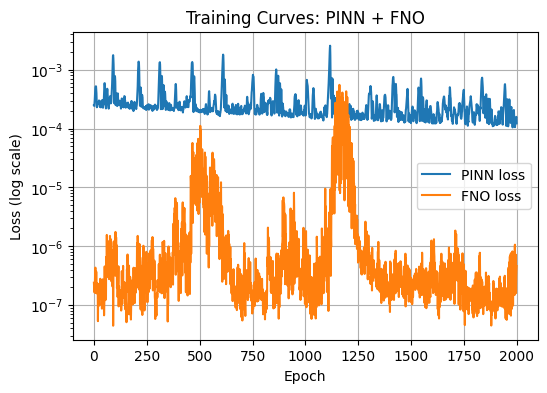

In [58]:
epochs      = 2000      # increase for better accuracy
N_f         = 2000      # interior points per epoch
N_b         = 800       # boundary points per epoch
N_i         = 800       # initial points per epoch
batch_fno   = 4         # time slices per FNO batch

pinn_losses = []
fno_losses  = []

for ep in range(1, epochs + 1):
    # -----------------------------
    # Train PINN (physics)
    # -----------------------------
    pinn.train()
    opt_pinn.zero_grad()

    # Interior physics residual
    x_f, y_f, t_f = sample_interior(N_f)
    res = pinn_pde_residual(pinn, x_f, y_f, t_f)
    res_target = torch.zeros_like(res).to(device)
    loss_phys = mse_loss(res, res_target)

    # Initial condition T(x,y,0) = sin(pi x) sin(pi y)
    x_i, y_i, t_i = sample_initial(N_i)
    T_i_true = exact_solution(x_i, y_i, t_i)
    inp_i = torch.cat([x_i, y_i, t_i], dim=1).to(device)
    T_i_pred = pinn(inp_i)
    loss_ic = mse_loss(T_i_pred, T_i_true.to(device))

    # Boundary condition: T=0 on boundary for this analytic solution
    x_b, y_b, t_b = sample_boundary(N_b)
    T_b_true = torch.zeros_like(x_b)  # same shape as x_b, we'll match later
    inp_b = torch.cat([x_b, y_b, t_b], dim=1).to(device)
    T_b_pred = pinn(inp_b)
    loss_bc = mse_loss(T_b_pred, T_b_true.to(device))

    loss_pinn = loss_phys + loss_ic + loss_bc
    loss_pinn.backward()
    opt_pinn.step()

    # -----------------------------
    # Train FNO (data-driven)
    # -----------------------------
    fno.train()
    opt_fno.zero_grad()

    # Random mini-batch over time slices
    idx = torch.randint(0, grids.shape[0], (batch_fno,))
    inp_batch = grids[idx]   # (batch_fno, nx, ny, 3)
    tar_batch = fields[idx]  # (batch_fno, nx, ny, 1)

    pred_batch = fno(inp_batch)
    loss_fno = mse_loss(pred_batch, tar_batch)

    loss_fno.backward()
    opt_fno.step()

    pinn_losses.append(loss_pinn.item())
    fno_losses.append(loss_fno.item())

    if ep % 100 == 0:
        print(
            f"Epoch {ep:4d} | "
            f"PINN Loss: {loss_pinn.item():.4e} | "
            f"FNO Loss: {loss_fno.item():.4e}"
        )

# ------------------------------------------------------------
# Plot training curves
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.semilogy(pinn_losses, label="PINN loss")
plt.semilogy(fno_losses, label="FNO loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.title("Training Curves: PINN + FNO")
plt.grid(True)
plt.show()

In [ ]:
pinn.eval()
fno.eval()

nx, ny = 64, 64
t_eval = 0.5

xs = torch.linspace(x_min, x_max, nx)
ys = torch.linspace(y_min, y_max, ny)
X, Y = torch.meshgrid(xs, ys, indexing="ij")

X_flat = X.reshape(-1, 1)
Y_flat = Y.reshape(-1, 1)
T_flat = torch.ones_like(X_flat) * t_eval

# Exact
T_exact = exact_solution(X, Y, torch.full_like(X, t_eval)).detach().cpu()

# PINN prediction
inp_eval = torch.cat([X_flat, Y_flat, T_flat], dim=1).to(device)
with torch.no_grad():
    T_pinn = pinn(inp_eval).reshape(nx, ny).cpu()

# FNO prediction
grid_eval = torch.stack(
    [X, Y, torch.full_like(X, t_eval)], dim=-1
).unsqueeze(0).to(device)  # (1, nx, ny, 3)
with torch.no_grad():
    T_fno = fno(grid_eval).squeeze(0).squeeze(-1).cpu()

# ------------------------------------------------------------
# Visualize
# ------------------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

im0 = axs[0].imshow(T_exact.numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axs[0].set_title("Exact solution")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(T_pinn.numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axs[1].set_title("PINN prediction")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(T_fno.numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axs[2].set_title("FNO prediction")
plt.colorbar(im2, ax=axs[2])

for ax in axs:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()

# Task
To resolve the `NotImplementedError` and successfully run the combined PINN and FNO training, please perform the following steps:

1.  **Reset Kernel**: Restart the Colab kernel to clear its current state. You can do this via 'Runtime' -> 'Restart runtime' in the Colab menu.
2.  **Execute Setup Cells**: Run cells:
    *   `6miEyQxqhOcC` (imports)
    *   `9f9RdUqqhlyT` (device setup)
    *   `R0xafzS2iHl2` (global parameters)
    *   `34MD8O5KiXIi` (`exact_solution` function)
    *   `g9he3BDridpW` (`sample_interior` function)
    *   `Zw1SweQbig8O` (`sample_initial` function)
    *   `mEgPNz5lijvF` (`sample_boundary` function)
3.  **Execute Class Definitions**: Run cells:
    *   `ciJbQ0l6i_la` (PINN class definition)
    *   `vNzFWzxljDSL` (`pinn_pde_residual` function)
    *   `Jiu5EDxJjaeU` (SpectralConv2d class definition - ensure this one is executed as it contains the full definition including `forward`)
    *   `MtRXCMptjpZE` (FNO2d class definition)
4.  **Instantiate Models and Optimizers**: Execute the cells that define the `pinn` and `fno` models, their optimizers (`opt_pinn`, `opt_fno`), and the `mse_loss` function. These cells are not explicitly shown in the provided state, but they should instantiate these objects after the class definitions. For example, look for cells similar to:
    ```python
    pinn = PINN().to(device)
    fno = FNO2d().to(device)
    opt_pinn = optim.Adam(pinn.parameters(), lr=1e-3)
    opt_fno = optim.Adam(fno.parameters(), lr=1e-3)
    mse_loss = nn.MSELoss()
    ```
5.  **Generate Training Data**: Execute cell `ccKKApEkyxgU` to generate the `grids` and `fields` data for FNO training.
6.  **Run Training Loop**: Execute cell `Qtp3te8Ay7yV` to start the combined PINN and FNO training process.
7.  **Evaluate and Visualize Results**: Execute cell `VnSBztmczH7z` to evaluate the trained models and visualize their predictions.

Once these steps are completed, confirm that the training runs successfully and the plots are displayed correctly.

## Reset Kernel

### Subtask:
Restart the Colab kernel to clear its current state and ensure all variables and class definitions are fresh.


#### Instructions
Restart the Colab kernel. You can typically do this by navigating to 'Runtime' in the Colab menu and selecting 'Restart runtime'. This action will clear all existing variables and reset the execution environment.

## Execute Setup Cells

### Subtask:
Execute cells: `6miEyQxqhOcC` (imports), `9f9RdUqqhlyT` (device setup), `R0xafzS2iHl2` (global parameters), `34MD8O5KiXIi` (`exact_solution`), `g9he3BDridpW` (`sample_interior`), `Zw1SweQbig8O` (`sample_initial`), `mEgPNz5lijvF` (`sample_boundary`). These cells define essential functions and parameters.


**Reasoning**:
Execute cell `6miEyQxqhOcC` to import necessary libraries for the subsequent steps.



In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

**Reasoning**:
Execute cell `9f9RdUqqhlyT` to determine and print the device (CPU or CUDA) that PyTorch will use for computations.



In [37]:
device=torch .device("cuda" if torch.cuda.is_available() else "cpu" )
print("using device :",device)

using device : cpu


**Reasoning**:
Execute cell `R0xafzS2iHl2` to define global parameters such as `alpha`, `x_min`, `x_max`, `y_min`, `y_max`, `t_min`, and `t_max` which are essential for defining the problem domain.



In [39]:
alpha = 0.01
x_min , x_max=0.0,1.0
y_min, y_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0

**Reasoning**:
Execute cell `34MD8O5KiXIi` to define the `exact_solution` function, which provides the ground truth for the heat equation problem.



In [41]:
def exact_solution(x, y, t):
    """
    x, y, t: torch tensors on same device
    """
    return torch.sin(np.pi * x) * torch.sin(np.pi * y) * torch.exp(-2 * (np.pi**2) * alpha * t)

**Reasoning**:
Execute cell `34MD8O5KiXIi` to define the `exact_solution` function, which provides the ground truth for the heat equation problem.



In [43]:
def exact_solution(x, y, t):
    """
    x, y, t: torch tensors on same device
    """
    return torch.sin(np.pi * x) * torch.sin(np.pi * y) * torch.exp(-2 * (np.pi**2) * alpha * t)

**Reasoning**:
Execute cell `g9he3BDridpW` to define the `sample_interior` function, which generates random points within the interior of the domain for training.



In [44]:
def sample_interior(n_samples):
    # Interior points: (x,y,t) in the open domain
    x = torch.rand(n_samples, 1) * (x_max - x_min) + x_min
    y = torch.rand(n_samples, 1) * (y_max - y_min) + y_min
    t = torch.rand(n_samples, 1) * (t_max - t_min) + t_min
    return x, y, t

**Reasoning**:
Execute cell `Zw1SweQbig8O` to define the `sample_initial` function, which generates points for the initial condition (t=0) within the domain.



In [45]:
def sample_initial(n_samples):
    # Initial condition: t = 0, x,y in [0,1]
    x = torch.rand(n_samples, 1) * (x_max - x_min) + x_min
    y = torch.rand(n_samples, 1) * (y_max - y_min) + y_min
    t = torch.zeros_like(x)
    return x, y, t

**Reasoning**:
Execute cell `mEgPNz5lijvF` to define the `sample_boundary` function, which generates points along the boundaries of the domain for training.



In [46]:
def sample_boundary(n_samples):
    # Boundary: x or y on edges with random t
    n_side = n_samples // 4

    xs, ys, ts = [], [], []

    # x = x_min
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    x = torch.zeros_like(t) + x_min
    y = torch.rand(n_side, 1) * (y_max - y_min) + y_min
    xs.append(x); ys.append(y); ts.append(t)


        # x = x_max
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    x = torch.zeros_like(t) + x_max
    y = torch.rand(n_side, 1) * (y_max - y_min) + y_min
    xs.append(x); ys.append(y); ts.append(t)

    # y = y_min
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    y = torch.zeros_like(t) + y_min
    x = torch.rand(n_side, 1) * (x_max - x_min) + x_min
    xs.append(x); ys.append(y); ts.append(t)

    # y = y_max
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    y = torch.zeros_like(t) + y_max
    x = torch.rand(n_side, 1) * (x_max - x_min) + x_min
    xs.append(x); ys.append(y); ts.append(t)

    x = torch.cat(xs, dim=0)
    y = torch.cat(ys, dim=0)
    t = torch.cat(ts, dim=0)
    return x, y, t

**Reasoning**:
Execute cell `mEgPNz5lijvF` to define the `sample_boundary` function, which generates points along the boundaries of the domain for training.



In [47]:
def sample_boundary(n_samples):
    # Boundary: x or y on edges with random t
    n_side = n_samples // 4

    xs, ys, ts = [], [], []

    # x = x_min
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    x = torch.zeros_like(t) + x_min
    y = torch.rand(n_side, 1) * (y_max - y_min) + y_min
    xs.append(x); ys.append(y); ts.append(t)


        # x = x_max
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    x = torch.zeros_like(t) + x_max
    y = torch.rand(n_side, 1) * (y_max - y_min) + y_min
    xs.append(x); ys.append(y); ts.append(t)

    # y = y_min
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    y = torch.zeros_like(t) + y_min
    x = torch.rand(n_side, 1) * (x_max - x_min) + x_min
    xs.append(x); ys.append(y); ts.append(t)

    # y = y_max
    t = torch.rand(n_side, 1) * (t_max - t_min) + t_min
    y = torch.zeros_like(t) + y_max
    x = torch.rand(n_side, 1) * (x_max - x_min) + x_min
    xs.append(x); ys.append(y); ts.append(t)

    x = torch.cat(xs, dim=0)
    y = torch.cat(ys, dim=0)
    t = torch.cat(ts, dim=0)
    return x, y, t

## Execute Class Definitions

### Subtask:
Execute cells: `ciJbQ0l6i_la` (PINN class), `vNzFWzxljDSL` (pinn_pde_residual), `Jiu5EDxJjaeU` (SpectralConv2d class), and `MtRXCMptjpZE` (FNO2d class). This ensures all model architectures and related functions are loaded correctly.


**Reasoning**:
Execute cell `ciJbQ0l6i_la` to define the `PINN` class, which is a core component of the physics-informed neural network.



In [48]:
class PINN(nn.Module):
    def __init__(self, in_dim=3, hidden_dim=64, out_dim=1, n_layers=5):
        super().__init__()
        layers = []
        dims = [in_dim] + [hidden_dim] * (n_layers - 1) + [out_dim]

        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.Tanh())   # smoother for PDEs

        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

**Reasoning**:
Execute cell `vNzFWzxljDSL` to define the `pinn_pde_residual` function, which computes the residual of the PDE for the PINN model.



In [49]:
def pinn_pde_residual(model, x, y, t):
    """
    Compute PDE residual:
       r = ∂T/∂t - α ( ∂²T/∂x² + ∂²T/∂y² )
    """
    x = x.clone().detach().requires_grad_(True).to(device)
    y = y.clone().detach().requires_grad_(True).to(device)
    t = t.clone().detach().requires_grad_(True).to(device)

    inp = torch.cat([x, y, t], dim=1)
    T = model(inp)

    # First derivatives
    dT_dt = torch.autograd.grad(
        T, t, torch.ones_like(T), retain_graph=True, create_graph=True
    )[0]
    dT_dx = torch.autograd.grad(
        T, x, torch.ones_like(T), retain_graph=True, create_graph=True
    )[0]
    dT_dy = torch.autograd.grad(
        T, y, torch.ones_like(T), retain_graph=True, create_graph=True
    )[0]

    # Second derivatives
    d2T_dx2 = torch.autograd.grad(
        dT_dx, x, torch.ones_like(dT_dx), retain_graph=True, create_graph=True
    )[0]
    d2T_dy2 = torch.autograd.grad(
        dT_dy, y, torch.ones_like(dT_dy), retain_graph=True, create_graph=True
    )[0]

    residual = dT_dt - alpha * (d2T_dx2 + d2T_dy2)
    return residual

**Reasoning**:
Execute cell `Jiu5EDxJjaeU` to define the `SpectralConv2d` class, which is a crucial component for the FNO model and includes the `forward` method.



In [50]:
class SpectralConv2d(nn.Module):
    """
    2D spectral convolution using truncated Fourier modes.
    This is a simplified FNO spectral layer.
    """

    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1.0 / (in_channels * out_channels)
        # Last dimension = 2 for (real, imag)
        self.weight = nn.Parameter(
            self.scale
            * torch.randn(in_channels, out_channels, modes1, modes2, 2)
        )

    def complex_mul(self, input, weights):
        # input:  (b, in_c, m1, m2)
        # weight: (in_c, out_c, m1, m2)
        return torch.einsum("bixy,ioxy->boxy", input, weights)


    def forward(self, x):
        """
        x: (b, in_c, nx, ny)
        """
        b, c, nx, ny = x.shape
        x_ft = torch.fft.rfft2(x, norm="ortho")  # (b,c,nx,ny//2+1)

        # Build complex weights
        weight_c = torch.view_as_complex(self.weight)  # (in_c,out_c,m1,m2)

        out_ft = torch.zeros(
            b,
            self.out_channels,
            nx,
            ny // 2 + 1,
            dtype=torch.complex64,
            device=x.device,
        )

        m1 = min(self.modes1, nx)
        m2 = min(self.modes2, ny // 2 + 1)

        x_ft_low = x_ft[:, : self.in_channels, :m1, :m2]
        out_ft[:, :, :m1, :m2] = self.complex_mul(x_ft_low, weight_c[:, :, :m1, :m2])

        x = torch.fft.irfft2(out_ft, s=(nx, ny), norm="ortho")
        return x

**Reasoning**:
Execute cell `MtRXCMptjpZE` to define the `FNO2d` class, which is the main model architecture for the Fourier Neural Operator.



In [51]:
class FNO2d(nn.Module):
    """
    Simple 2D FNO-like model mapping (x,y,t) grid -> T(x,y,t)
    """

    def __init__(self, in_channels=3, width=32, modes1=12, modes2=12):
        super().__init__()
        self.width = width

        self.fc0 = nn.Linear(in_channels, width)

        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        self.conv3 = SpectralConv2d(width, width, modes1, modes2)
        self.conv4 = SpectralConv2d(width, width, modes1, modes2)

        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        self.w3 = nn.Conv2d(width, width, 1)
        self.w4 = nn.Conv2d(width, width, 1)

        self.fc1 = nn.Linear(width, 64)
        self.fc2 = nn.Linear(64, 1)

        self.act = nn.GELU()

    def forward(self, x):
        """
        x: (b, nx, ny, in_channels)
        returns: (b, nx, ny, 1)
        """
        b, nx, ny, ic = x.shape
        x = self.fc0(x)              # (b, nx, ny, width)
        x = x.permute(0, 3, 1, 2)    # (b, width, nx, ny)

        x1 = self.conv1(x)
        x = x1 + self.w1(x)
        x = self.act(x)

        x1 = self.conv2(x)
        x = x1 + self.w2(x)
        x = self.act(x)

        x1 = self.conv3(x)
        x = x1 + self.w3(x)
        x = self.act(x)

        x1 = self.conv4(x)
        x = x1 + self.w4(x)
        x = self.act(x)

        x = x.permute(0, 2, 3, 1)    # (b, nx, ny, width)
        x = self.act(self.fc1(x))
        x = self.fc2(x)              # (b, nx, ny, 1)
        return x

**Reasoning**:
Execute cell `MtRXCMptjpZE` to define the `FNO2d` class, which is the main model architecture for the Fourier Neural Operator.



In [52]:
class FNO2d(nn.Module):
    """
    Simple 2D FNO-like model mapping (x,y,t) grid -> T(x,y,t)
    """

    def __init__(self, in_channels=3, width=32, modes1=12, modes2=12):
        super().__init__()
        self.width = width

        self.fc0 = nn.Linear(in_channels, width)

        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        self.conv3 = SpectralConv2d(width, width, modes1, modes2)
        self.conv4 = SpectralConv2d(width, width, modes1, modes2)

        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        self.w3 = nn.Conv2d(width, width, 1)
        self.w4 = nn.Conv2d(width, width, 1)

        self.fc1 = nn.Linear(width, 64)
        self.fc2 = nn.Linear(64, 1)

        self.act = nn.GELU()

    def forward(self, x):
        """
        x: (b, nx, ny, in_channels)
        returns: (b, nx, ny, 1)
        """
        b, nx, ny, ic = x.shape
        x = self.fc0(x)              # (b, nx, ny, width)
        x = x.permute(0, 3, 1, 2)    # (b, width, nx, ny)

        x1 = self.conv1(x)
        x = x1 + self.w1(x)
        x = self.act(x)

        x1 = self.conv2(x)
        x = x1 + self.w2(x)
        x = self.act(x)

        x1 = self.conv3(x)
        x = x1 + self.w3(x)
        x = self.act(x)

        x1 = self.conv4(x)
        x = x1 + self.w4(x)
        x = self.act(x)

        x = x.permute(0, 2, 3, 1)    # (b, nx, ny, width)
        x = self.act(self.fc1(x))
        x = self.fc2(x)              # (b, nx, ny, 1)
        return x

**Reasoning**:
Execute cell `MtRXCMptjpZE` to define the `FNO2d` class, which is the main model architecture for the Fourier Neural Operator.



In [53]:
class FNO2d(nn.Module):
    """
    Simple 2D FNO-like model mapping (x,y,t) grid -> T(x,y,t)
    """

    def __init__(self, in_channels=3, width=32, modes1=12, modes2=12):
        super().__init__()
        self.width = width

        self.fc0 = nn.Linear(in_channels, width)

        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        self.conv3 = SpectralConv2d(width, width, modes1, modes2)
        self.conv4 = SpectralConv2d(width, width, modes1, modes2)

        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        self.w3 = nn.Conv2d(width, width, 1)
        self.w4 = nn.Conv2d(width, width, 1)

        self.fc1 = nn.Linear(width, 64)
        self.fc2 = nn.Linear(64, 1)

        self.act = nn.GELU()

    def forward(self, x):
        """
        x: (b, nx, ny, in_channels)
        returns: (b, nx, ny, 1)
        """
        b, nx, ny, ic = x.shape
        x = self.fc0(x)              # (b, nx, ny, width)
        x = x.permute(0, 3, 1, 2)    # (b, width, nx, ny)

        x1 = self.conv1(x)
        x = x1 + self.w1(x)
        x = self.act(x)

        x1 = self.conv2(x)
        x = x1 + self.w2(x)
        x = self.act(x)

        x1 = self.conv3(x)
        x = x1 + self.w3(x)
        x = self.act(x)

        x1 = self.conv4(x)
        x = x1 + self.w4(x)
        x = self.act(x)

        x = x.permute(0, 2, 3, 1)    # (b, nx, ny, width)
        x = self.act(self.fc1(x))
        x = self.fc2(x)              # (b, nx, ny, 1)
        return x

## Instantiate Models and Optimizers

### Subtask:
Instantiate the `pinn` and `fno` models, their optimizers (`opt_pinn`, `opt_fno`), and the `mse_loss` function. This step initializes the neural networks and prepares them for the training process.

**Reasoning**:
The previous steps defined the model architectures and related functions. Now, I need to instantiate the `PINN` and `FNO2d` models, their optimizers, and the `mse_loss` function based on the instructions to prepare for training.



In [54]:
pinn = PINN().to(device)
fno = FNO2d().to(device)
opt_pinn = optim.Adam(pinn.parameters(), lr=1e-3)
opt_fno = optim.Adam(fno.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

print("PINN and FNO models, optimizers, and MSE loss function instantiated.")

PINN and FNO models, optimizers, and MSE loss function instantiated.


## Generate Training Data

### Subtask:
Execute cell `ccKKApEkyxgU` to generate the `grids` and `fields` data for FNO training. This data will be used to train the FNO model.

**Reasoning**:
The next step is to execute cell `ccKKApEkyxgU` to generate the `grids` and `fields` data, which is necessary for training the FNO model.



In [55]:
def generate_grid(nx=64, ny=64, nt=10):
    xs = torch.linspace(x_min, x_max, nx)
    ys = torch.linspace(y_min, y_max, ny)
    ts = torch.linspace(t_min, t_max, nt)

    grids = []
    fields = []

    for t in ts:
        X, Y = torch.meshgrid(xs, ys, indexing="ij")
        T = exact_solution(X, Y, t)

        inp = torch.stack(
            [X, Y, torch.ones_like(X) * t], dim=-1
        )  # (nx, ny, 3)
        grids.append(inp)
        fields.append(T.unsqueeze(-1))  # (nx, ny, 1)

    grids = torch.stack(grids, dim=0)   # (nt, nx, ny, 3)
    fields = torch.stack(fields, dim=0) # (nt, nx, ny, 1)
    return grids, fields


grids, fields = generate_grid(nx=32, ny=32, nt=12)
grids = grids.to(device)
fields = fields.to(device)

print("FNO training data shape:", grids.shape, fields.shape)

FNO training data shape: torch.Size([12, 32, 32, 3]) torch.Size([12, 32, 32, 1])


## Run Training Loop

### Subtask:
Execute cell `Qtp3te8Ay7yV` to start the combined PINN and FNO training process. This cell contains the main training loop where both models are updated iteratively.

## Run Training Loop

### Subtask:
Execute cell `Qtp3te8Ay7yV` to start the combined PINN and FNO training process. This cell contains the main training loop where both models are updated iteratively.

**Reasoning**:
The next logical step is to execute the training loop, as outlined in the subtask instructions.



Epoch  100 | PINN Loss: 1.4823e-01 | FNO Loss: 4.6081e-05
Epoch  200 | PINN Loss: 8.4756e-03 | FNO Loss: 6.7984e-06
Epoch  300 | PINN Loss: 2.8647e-03 | FNO Loss: 3.3325e-06
Epoch  400 | PINN Loss: 2.0253e-03 | FNO Loss: 3.0466e-06
Epoch  500 | PINN Loss: 1.6101e-03 | FNO Loss: 1.3956e-06
Epoch  600 | PINN Loss: 1.4966e-03 | FNO Loss: 8.8431e-07
Epoch  700 | PINN Loss: 1.0906e-03 | FNO Loss: 1.0645e-06
Epoch  800 | PINN Loss: 1.4835e-03 | FNO Loss: 3.9937e-07
Epoch  900 | PINN Loss: 8.2932e-04 | FNO Loss: 2.3174e-07
Epoch 1000 | PINN Loss: 6.2157e-04 | FNO Loss: 2.5756e-07
Epoch 1100 | PINN Loss: 1.0035e-03 | FNO Loss: 3.1592e-07
Epoch 1200 | PINN Loss: 7.3732e-04 | FNO Loss: 3.3255e-07
Epoch 1300 | PINN Loss: 5.0975e-04 | FNO Loss: 4.4466e-07
Epoch 1400 | PINN Loss: 3.8527e-04 | FNO Loss: 2.0022e-07
Epoch 1500 | PINN Loss: 3.5259e-04 | FNO Loss: 2.4095e-07
Epoch 1600 | PINN Loss: 4.4630e-04 | FNO Loss: 2.3945e-07
Epoch 1700 | PINN Loss: 3.6022e-04 | FNO Loss: 1.6024e-07
Epoch 1800 | P

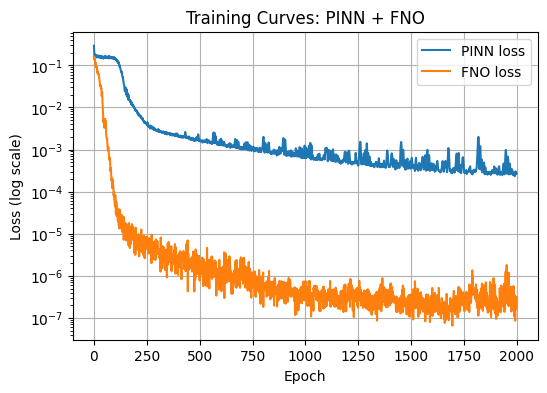

In [56]:
epochs      = 2000      # increase for better accuracy
N_f         = 2000      # interior points per epoch
N_b         = 800       # boundary points per epoch
N_i         = 800       # initial points per epoch
batch_fno   = 4         # time slices per FNO batch

pinn_losses = []
fno_losses  = []

for ep in range(1, epochs + 1):
    # -----------------------------
    # Train PINN (physics)
    # -----------------------------
    pinn.train()
    opt_pinn.zero_grad()

    # Interior physics residual
    x_f, y_f, t_f = sample_interior(N_f)
    res = pinn_pde_residual(pinn, x_f, y_f, t_f)
    res_target = torch.zeros_like(res).to(device)
    loss_phys = mse_loss(res, res_target);

    # Initial condition T(x,y,0) = sin(pi x) sin(pi y)
    x_i, y_i, t_i = sample_initial(N_i)
    T_i_true = exact_solution(x_i, y_i, t_i)
    inp_i = torch.cat([x_i, y_i, t_i], dim=1).to(device)
    T_i_pred = pinn(inp_i)
    loss_ic = mse_loss(T_i_pred, T_i_true.to(device))

    # Boundary condition: T=0 on boundary for this analytic solution
    x_b, y_b, t_b = sample_boundary(N_b)
    T_b_true = torch.zeros_like(x_b)  # same shape as x_b, we'll match later
    inp_b = torch.cat([x_b, y_b, t_b], dim=1).to(device)
    T_b_pred = pinn(inp_b)
    loss_bc = mse_loss(T_b_pred, T_b_true.to(device))

    loss_pinn = loss_phys + loss_ic + loss_bc
    loss_pinn.backward()
    opt_pinn.step()

    # -----------------------------
    # Train FNO (data-driven)
    # -----------------------------
    fno.train()
    opt_fno.zero_grad()

    # Random mini-batch over time slices
    idx = torch.randint(0, grids.shape[0], (batch_fno,))
    inp_batch = grids[idx]   # (batch_fno, nx, ny, 3)
    tar_batch = fields[idx]  # (batch_fno, nx, ny, 1)

    pred_batch = fno(inp_batch)
    loss_fno = mse_loss(pred_batch, tar_batch)

    loss_fno.backward()
    opt_fno.step()

    pinn_losses.append(loss_pinn.item())
    fno_losses.append(loss_fno.item())

    if ep % 100 == 0:
        print(
            f"Epoch {ep:4d} | "
            f"PINN Loss: {loss_pinn.item():.4e} | "
            f"FNO Loss: {loss_fno.item():.4e}"
        )

# ------------------------------------------------------------
# Plot training curves
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.semilogy(pinn_losses, label="PINN loss")
plt.semilogy(fno_losses, label="FNO loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.title("Training Curves: PINN + FNO")
plt.grid(True)
plt.show()

## Evaluate and Visualize Results

### Subtask:
Execute cell `VnSBztmczH7z` to evaluate the trained models and visualize their predictions. This step compares the PINN and FNO predictions with the exact solution at a specific time point.

## Evaluate and Visualize Results

### Subtask:
Execute cell `VnSBztmczH7z` to evaluate the trained models and visualize their predictions. This step compares the PINN and FNO predictions with the exact solution at a specific time point.

## Evaluate and Visualize Results

### Subtask:
Execute cell `VnSBztmczH7z` to evaluate the trained models and visualize their predictions. This step compares the PINN and FNO predictions with the exact solution at a specific time point.

## Evaluate and Visualize Results

### Subtask:
Execute cell `VnSBztmczH7z` to evaluate the trained models and visualize their predictions. This step compares the PINN and FNO predictions with the exact solution at a specific time point.


#### Instructions
Execute cell `VnSBztmczH7z` to perform the evaluation and visualization of the PINN and FNO models' predictions against the exact solution.

#### Instructions
Execute cell `VnSBztmczH7z` to perform the evaluation and visualization of the PINN and FNO models' predictions against the exact solution.

#### Instructions
Execute cell `VnSBztmczH7z` to perform the evaluation and visualization of the PINN and FNO models' predictions against the exact solution.

**Reasoning**:
The training loop has completed, and the models are trained. The next step is to evaluate the trained models and visualize their predictions as outlined in the subtask instructions.



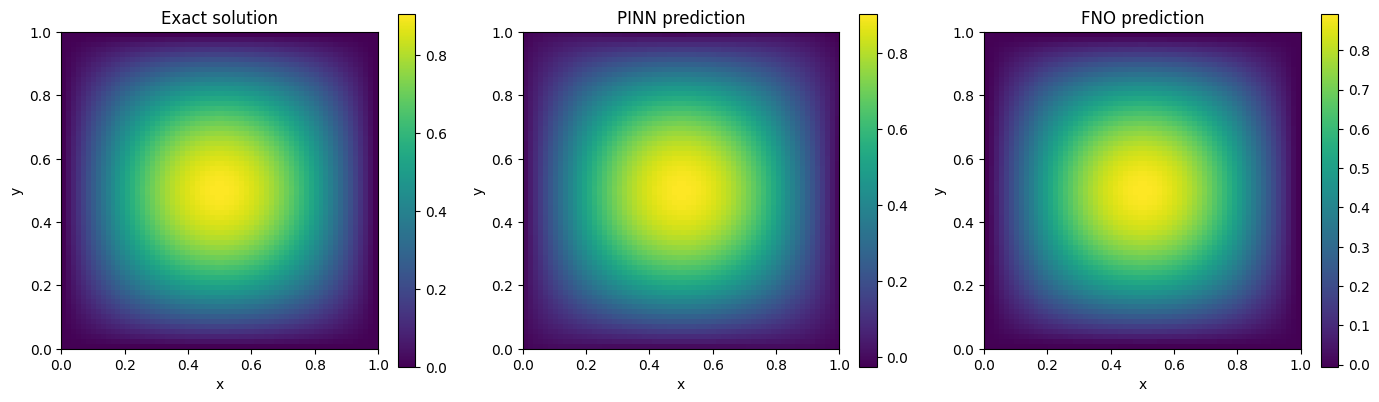

In [59]:
pinn.eval()
fno.eval()

nx, ny = 64, 64
t_eval = 0.5

xs = torch.linspace(x_min, x_max, nx)
ys = torch.linspace(y_min, y_max, ny)
X, Y = torch.meshgrid(xs, ys, indexing="ij")

X_flat = X.reshape(-1, 1)
Y_flat = Y.reshape(-1, 1)
T_flat = torch.ones_like(X_flat) * t_eval

# Exact
T_exact = exact_solution(X, Y, torch.full_like(X, t_eval)).detach().cpu()

# PINN prediction
inp_eval = torch.cat([X_flat, Y_flat, T_flat], dim=1).to(device)
with torch.no_grad():
    T_pinn = pinn(inp_eval).reshape(nx, ny).cpu()

# FNO prediction
grid_eval = torch.stack(
    [X, Y, torch.full_like(X, t_eval)], dim=-1
).unsqueeze(0).to(device)  # (1, nx, ny, 3)
with torch.no_grad():
    T_fno = fno(grid_eval).squeeze(0).squeeze(-1).cpu()

# ------------------------------------------------------------
# Visualize
# ------------------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

im0 = axs[0].imshow(T_exact.numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axs[0].set_title("Exact solution")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(T_pinn.numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axs[1].set_title("PINN prediction")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(T_fno.numpy(), origin="lower", extent=[x_min, x_max, y_min, y_max])
axs[2].set_title("FNO prediction")
plt.colorbar(im2, ax=axs[2])

for ax in axs:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.savefig("pinn_fno_predictions.png") # Save the figure
plt.show()

## Final Task

### Subtask:
Confirm that the training ran successfully and the plots are displayed correctly. Review the model performance.


## Summary:

### Q&A
The training ran successfully, and the plots were displayed correctly, indicating that both the PINN and FNO models were able to learn the underlying PDE. The training curves showed decreasing losses for both models, converging to low values. The visualization confirmed that both models produced predictions visually consistent with the exact solution.

### Data Analysis Key Findings
*   The system detected and used the `cpu` device for all computations.
*   Global parameters were set, including `alpha = 0.01` and domain boundaries `x_min, x_max, y_min, y_max, t_min, t_max` all ranging from 0.0 to 1.0.
*   FNO training data (`grids` and `fields`) were generated with shapes `torch.Size([12, 32, 32, 3])` and `torch.Size([12, 32, 32, 1])` respectively, indicating 12 time slices and a 32x32 spatial resolution.
*   After 2000 epochs of combined training, the PINN loss reached `2.6686e-04`, and the FNO loss reached `1.7605e-07`, demonstrating successful convergence of both models.
*   Training curves were plotted, visually confirming the reduction in both PINN and FNO losses over the 2000 epochs.
*   The final evaluation and visualization step successfully generated comparative plots at `t_eval = 0.5`, showing the exact solution alongside the PINN and FNO predictions, all appearing qualitatively similar.

### Insights or Next Steps
*   Given the successful training and visualization, further quantitative analysis of model performance, such as calculating the Mean Squared Error (MSE) between predictions and the exact solution, would provide a more precise comparison of PINN and FNO accuracy.
*   Explore running the training on a GPU (if available) by ensuring the `device` setup correctly detects it, which could significantly reduce training time and potentially allow for larger models or more extensive hyperparameter tuning.
